In [25]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [27]:
sess = sess_use()
print(sess.recinfo)

filename: /data3/Anisomycin/Recording_Rats/Creampuff/2024_07_17_Anisomycin/Creampuff_anisomycin.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [28]:
print(sess.eegfile)

duration: 15859.71 seconds 
duration: 4.41 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [29]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal(channel_indx=sess.recinfo.good_channels)
buffer_add = 0.55  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=6, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs


Existing artifact epochs file loaded
Total artifact time = 98.9 seconds


12 epochs
Snippet: 
       start      stop label
0  134.9812  151.4292      
1  157.4276  158.5564      
2  205.2948  232.3292      
3  338.7292  339.8540      
4  723.7196  751.3900      

<Axes: >

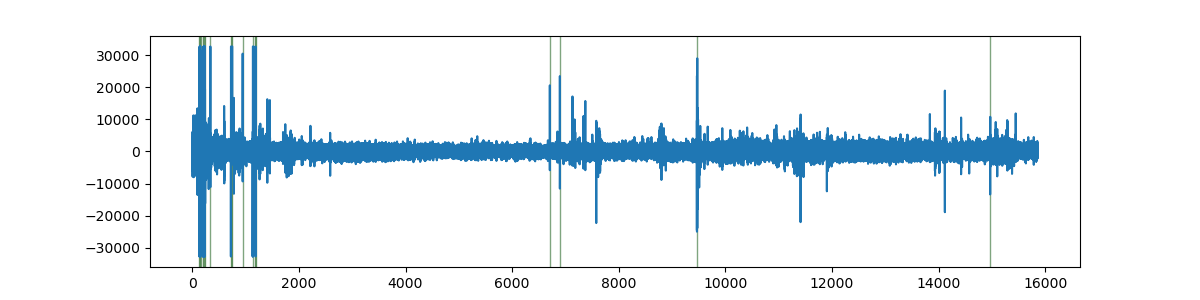

In [30]:
%matplotlib widget

chan_plot = 5
plot_signal_w_epochs(signal, chan_plot, art_epochs)

### Write to Spyking-Circus `dead_times.txt` file

In [23]:
from neuropy.io import SpykingCircusIO
SpykingCircusIO.write_epochs(sess.basepath / 'dead_times.txt', art_epochs)

dead_times.txt created


#### Code below to modify epochs manually if necessary

In [10]:
# # Add in epochs manually after inspection in neuroscope - then re-run above to check!

# # individual epoch
# # t1 = 55*60 + 21
# # t2 = 55*60 + 27.4
# # art_epochs = art_epochs.add_epoch_manually(t1, t2)

# # List of epochs
# epochs_to_add =np.array([[729.2412, 729.95], [27*60+52.6, 27*60+54.1], [41*60+39.3, 41*60+40.75]])
# art_epochs = art_epochs.add_epoch_manually(epochs_to_add[:, 0], epochs_to_add[:, 1])
# sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
# art_epochs.save(art_epochs_file)

/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.art_epochs.npy saved


### Code below to import updated epochs after manual adjustment in Neuroscope!

In [ ]:
# Note that Neuroscope is super buggy with adding events to existing files! One tactic is to create an .ar2 file and then add 
# in any adjustments then merge.

# art_epochs_ns = sess.recinfo.event_to_epochs(evt_file=sess.filePrefix.with_suffix('.evt.ar2'))
# art_epochs_ns

In [ ]:
# Merge files and export!
# art_epochs_merge = art_epochs.__add__(art_epochs_ns).merge(0)
# art_epochs_merge.save(art_epochs_file)
# art_epochs = art_epochs_merge
# sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
# art_epochs

## Define probe group

/data3/Anisomycin/Recording_Rats/Creampuff/2024_07_17_Anisomycin/Creampuff_anisomycin.probegroup.npy saved


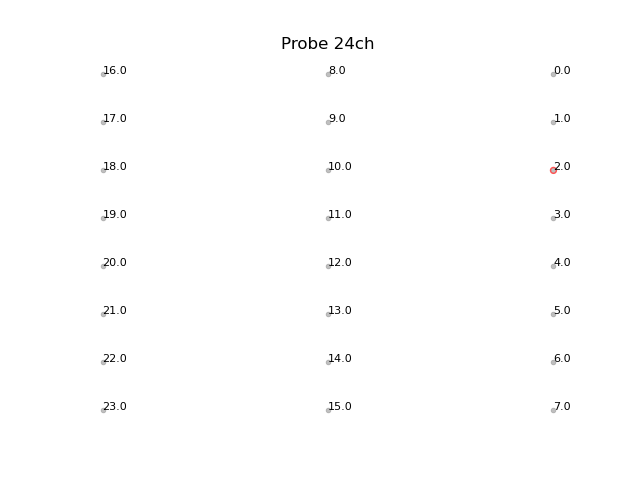

In [34]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=3, contacts_per_column=8, xpitch=250,
                   ypitch=20, channel_id=np.arange(23, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [35]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 20

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [20]
1256 epochs remaining with durations within (1,20)
/data3/Anisomycin/Recording_Rats/Creampuff/2024_07_17_Anisomycin/Creampuff_anisomycin.theta_epochs.npy saved


## Detect SWR Epochs

In [37]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 20
thresh = (3, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = True  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [20]
1311 epochs remaining with durations within (0.05,0.45)
/data3/Anisomycin/Recording_Rats/Creampuff/2024_07_17_Anisomycin/Creampuff_anisomycin.ripple_epochs.npy saved


## Import neurons

In [99]:
from neuropy.io.phyio import PhyIO
from neuropy.core.neurons import Neurons
phy_dir = sorted(sess.basepath.glob("**/params.py"))[0].parent
sess.phy = PhyIO(dirname=phy_dir)

sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, neuron_ids=sess.phy.neuron_ids,
                       neuron_type=sess.phy.cluster_info["group"], waveforms=sess.phy.waveforms, 
                       waveforms_amplitude=sess.phy.waveforms_amplitude, sampling_rate=sess.recinfo.dat_sampling_rate,
                       peak_channels=sess.phy.peak_channels, shank_ids=sess.phy.shank_ids)

for sh in np.unique(sess.neurons.shank_ids.astype(int)):
    sess.recinfo.write_neurons(sess.neurons.neuron_slice(np.where(sess.neurons.shank_ids == sh)[0]), suffix_num=sh)

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


## Detect PBE epochs

In [103]:
from neuropy.analyses.spkepochs import detect_pbe_epochs
bin_size=0.01
thresh = (2.5, None)
edge_cutoff = 0.5
duration = (0.1, None)
distance = None

# Collect MUA
sess.mua = sess.neurons.get_mua(bin_size=bin_size)

# Detect PBEs
sess.pbe = detect_pbe_epochs(sess.mua, thresh=thresh, edge_cutoff=edge_cutoff, duration=duration, distance=distance)
pbe_epochs_file = sess.filePrefix.with_suffix(".pbe_epochs.npy")
sess.pbe.save(pbe_epochs_file)
sess.recinfo.write_epochs(sess.pbe, ext='pbe')

811 epochs reamining with durations within (0.1,None)
/data3/Anisomycin/Recording_Rats/Creampuff/2024_07_17_Anisomycin/Creampuff_anisomycin.pbe_epochs.npy saved


# Wavelet Analysis

### Start with Theta

In [15]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

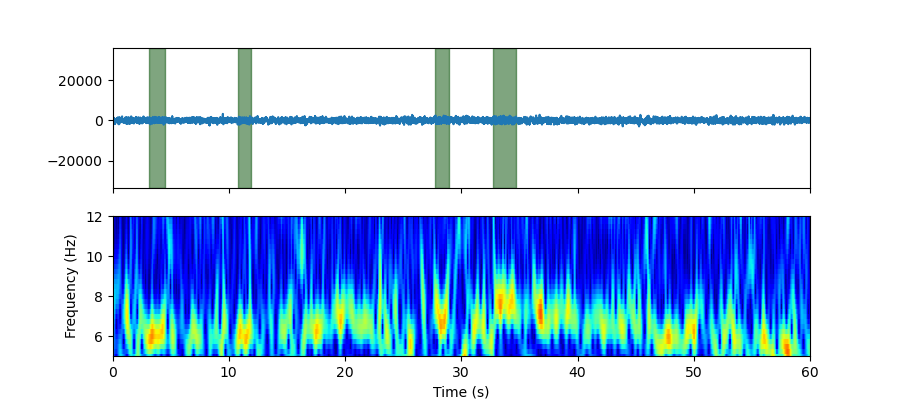

In [16]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

Events [ 334  335  336 ... 1491 1492 1493] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

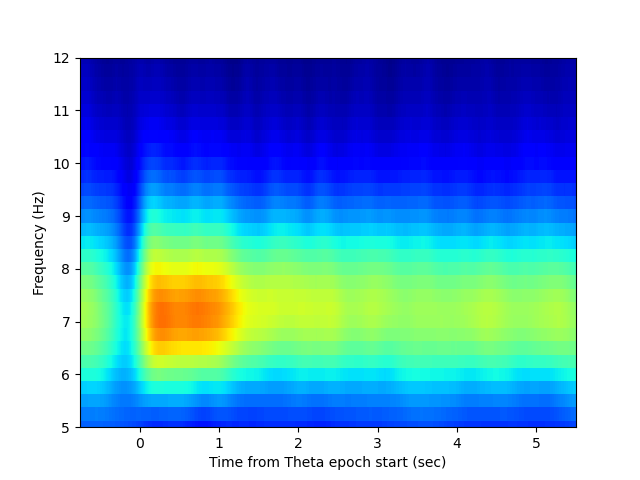

In [17]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [18]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

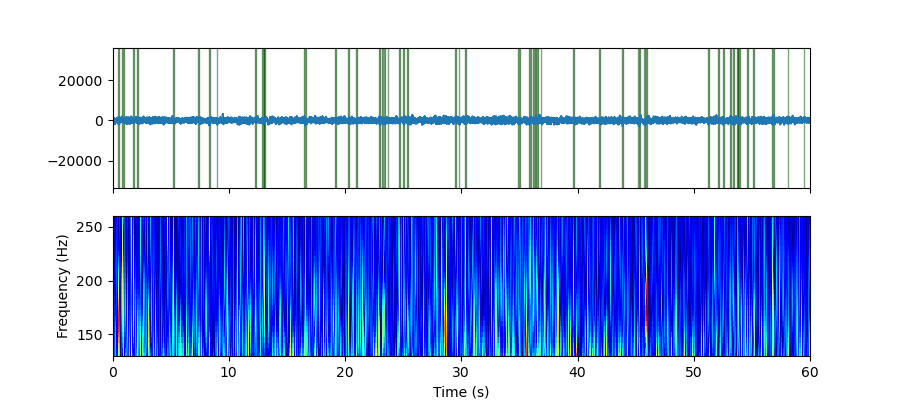

In [19]:
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

Events [ 4921  4922  4923 ... 17524 17525 17526] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

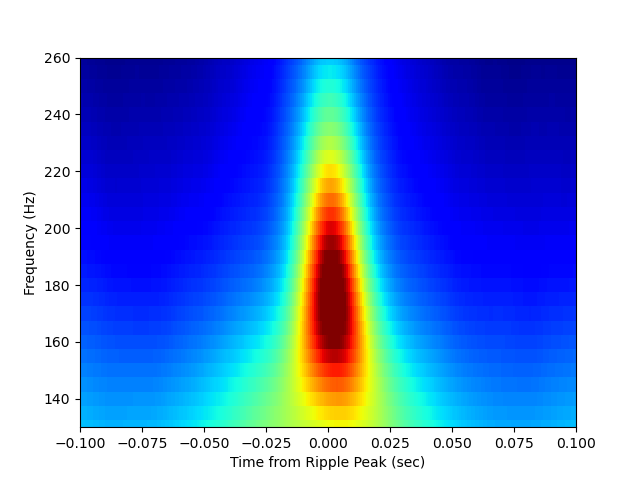

In [20]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-CS analyses

In [ ]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [ ]:
import tracefc.io.traceio as traceio

process_csn, process_cs, process_cs2 = True, True, True  # set flags for running code below
if sess_name.find("recall") == 0:
    # For tone recall CS+
    cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected during {sess_name} tone recall')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} control tone recall')
    print(csn_starts.head(6))
    
    # For CS+ at end of control_tone_recall
    cs2_starts, cs2_ends, cs2_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs2_starts.shape[0]} CS+ events detected during {sess_name} control tone recall')
    print(cs2_starts.head(6))
elif sess_name.find("habituation") == 0:
    # For control tone habituation CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} tone habituation')
    print(csn_starts.head(6))

    process_cs, process_cs2 = False, False
    
elif sess_name.find("training") == 0:
    # For control tone habituation CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} tone habituation')
    print(csn_starts.head(6))

    # For training CS+
    cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected during {sess_name} training')
    print(cs_starts.head(6))

    process_cs2 = False
    

In [ ]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

In [ ]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = ttl_lag=pd.Timedelta(0.95, unit="seconds")

# CS+
if process_cs:
    cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)

    cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_ends, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

    # Export to neuroscope
    cs_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ""})
    sess.recinfo.write_epochs(cs_epochs, ext="csp")

    # Save to neuropy
    cs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
    cs_epochs.save(cs_file)

# CS-
csn_oe_start_df, csn_start_diff = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2, return_diff=True)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)

csn_oe_stop_df, csn_stop_diff = traceio.trace_ttl_to_openephys(csn_ends, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2, return_diff=True)

# Convert to times in combined eeg file
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

# Export to neuroscope
csn_epochs = Epoch({"start": csn_starts_combined, "stop": csn_stops_combined, "label": ""})
sess.recinfo.write_epochs(csn_epochs, ext="csn")

# Save to neuropy
csn_file = sess.filePrefix.with_suffix(".csn_epochs.npy")
csn_epochs.save(csn_file)


# CS+ 2
if process_cs2:
    cs2_oe_start_df = traceio.trace_ttl_to_openephys(cs2_starts, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs2_starts_combined = oeio.recording_events_to_combined_time(cs2_oe_start_df, sync_df)

    cs2_oe_stop_df = traceio.trace_ttl_to_openephys(cs2_ends, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs2_stops_combined = oeio.recording_events_to_combined_time(cs2_oe_stop_df, sync_df)

    # Export to neuroscope
    cs2_epochs = Epoch({"start": cs2_starts_combined, "stop": cs2_stops_combined, "label": ""})
    sess.recinfo.write_epochs(cs2_epochs, ext="cs2")

    # Save to neuropy
    cs2_file = sess.filePrefix.with_suffix(".cs2_epochs.npy")
    cs2_epochs.save(cs2_file)


## Theta mean spectrogram

In [ ]:
from tracefc.plotting.signals import plot_cs_mean_wavelet
cs_buffer = (5, 45)

# For recall sessions
if sess_name.find("recall") == 0:
    _, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)
    _, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    plot_cs_mean_wavelet(wv_theta, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
    ax[5].set_title('CS+ at end of control tone recall session')

if sess_name.find("training") == 0: # for training sessions
    _, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 1, 5], layout='tight', sharex=True)
    _, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])

    # Change red line to solid
    line_ind = np.where([isinstance(a, plt.Line2D) for a in ax[0].get_children()])[0][0]
    ax[0].get_children()[line_ind].set_linestyle('-')
    
elif sess_name.find("habituation") == 0: # For habituation sessions
    _, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[1, 5], layout='tight', sharex=True)

    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=None, ax=ax[:2])

## Ripple mean spectrogram

In [ ]:
cs_buffer = (5, 45)

# For recall sessions
if sess_name.find("recall") == 0:
    _, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)
    
    _, std_sxx = plot_cs_mean_wavelet(wv_swr, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    plot_cs_mean_wavelet(wv_swr, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
    ax[5].set_title('CS+ at end of control tone recall session')

elif sess_name.find("training") == 0:
    _, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 1, 5], layout='tight', sharex=True)
    
    _, std_sxx = plot_cs_mean_wavelet(wv_swr, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    # Change red line to solid
    line_ind = np.where([isinstance(a, plt.Line2D) for a in ax[0].get_children()])[0][0]
    ax[0].get_children()[line_ind].set_linestyle('-')
    
elif sess_name.find("habituation") == 0: # For habituation sessions
    _, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[1, 5], layout='tight', sharex=True)
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=None, ax=ax[:2])

## Save notebook to working directory

In [ ]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")